In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from src.datasets.datasets import CPDDatasets
from src.ensembles.ensembles import EnsembleCPDModel
from src.metrics.evaluation_pipelines import (
    all_cusums_evaluation_pipeline,
    all_distances_evaluation_pipeline,
    evaluation_pipeline,
)
from src.metrics.metrics_utils import collect_model_predictions_on_set, compute_stds
from src.utils.calibration import (
    calibrate_all_models_in_ensemble,
    calibrate_single_model,  # noqa: F401
    manually_temperature_calibrate_all_models_in_ensemble,  # noqa: F401
    plot_calibration_curves,
)
from src.utils.fix_seeds import fix_seeds
from torch.utils.data import DataLoader

SEED = 42
fix_seeds(SEED)

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


# BCE HAR

In [3]:
model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [4]:
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [41]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        ens_bce, test_dataloader, model_type="ensemble", device="cpu"
    )
)

test_out_flat = torch.vstack(test_out_bank).flatten()
test_labels_flat = torch.vstack(test_labels_bank).flatten()
test_uncertainties_flat = torch.vstack(test_uncertainties_bank).flatten()

test_out_flat.shape, test_labels_flat.shape, test_uncertainties_flat.shape

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.80it/s]


(torch.Size([26740]), torch.Size([26740]), torch.Size([26740]))

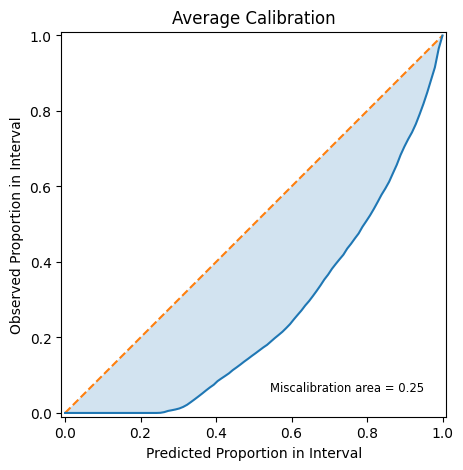

In [42]:
uct.viz.plot_calibration(
    test_out_flat.numpy(), test_uncertainties_flat.numpy(), test_labels_flat.numpy()
);

### Mean Ensemble

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:01<00:00, 17.86it/s]


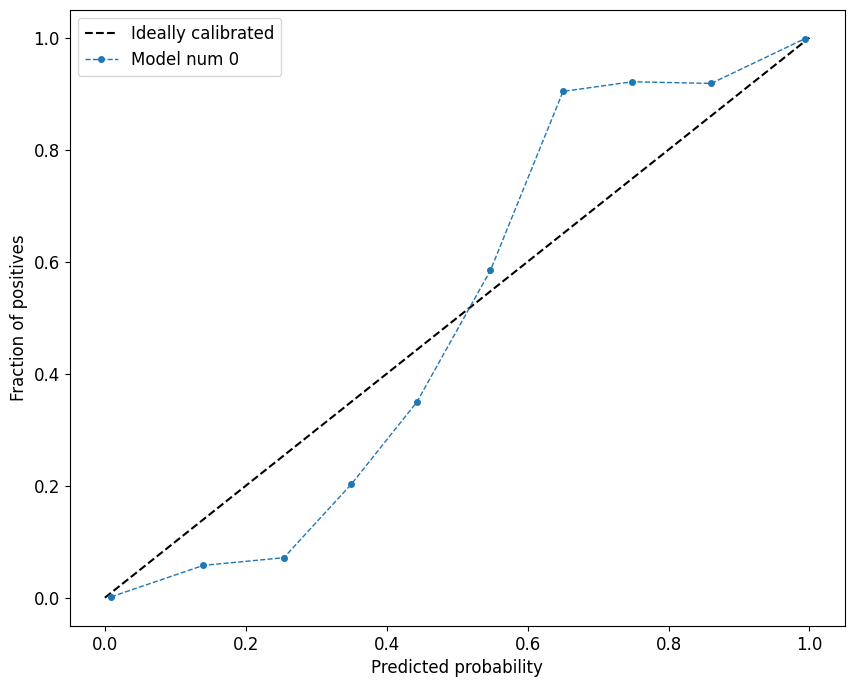

In [6]:
plot_calibration_curves([ens_bce], test_dataloader, model_type="ensemble")

### All single models

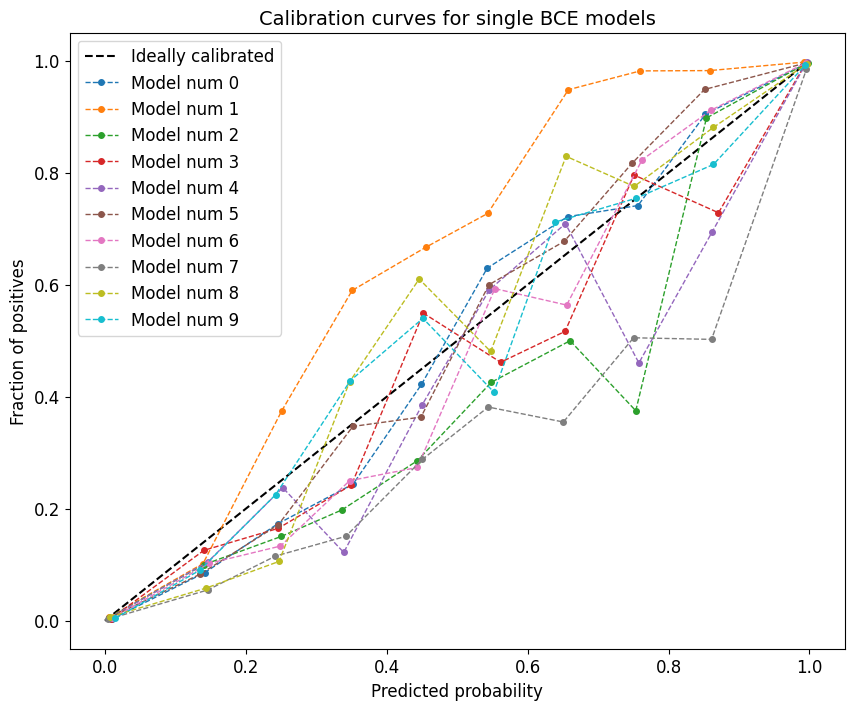

In [16]:
title = "Calibration curves for single BCE models"

plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title);

### Try calibration

100%|██████████| 21/21 [00:00<00:00, 29.15it/s]


Before temperature - NLL: 0.059, ECE: 0.007
Optimal temperature: 2.134
After temperature - NLL: 0.039, ECE: 0.003


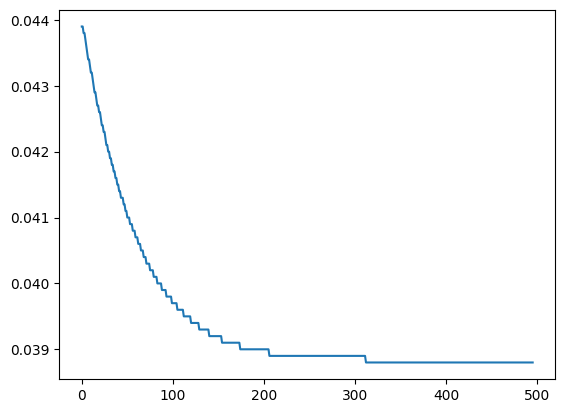

In [5]:
core_model = ens_bce.models_list[2].model
core_model.temperature = 1

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    lr=1e-2,
    max_iter=500,
    verbose=True,
    device="cpu",
    return_loss=True,
)

plt.plot(loss_history);

In [6]:
uncalibrate_all_models_in_ensemble(ens_bce)

100%|██████████| 21/21 [00:00<00:00, 31.43it/s]


Before temperature - NLL: 0.062, ECE: 0.008


 19%|█▉        | 4/21 [00:00<00:00, 33.01it/s]

Optimal temperature: 1.758
After temperature - NLL: 0.047, ECE: 0.002


100%|██████████| 21/21 [00:00<00:00, 32.93it/s]


Before temperature - NLL: 0.060, ECE: 0.006


 19%|█▉        | 4/21 [00:00<00:00, 33.10it/s]

Optimal temperature: 1.840
After temperature - NLL: 0.043, ECE: 0.004


100%|██████████| 21/21 [00:00<00:00, 32.66it/s]


Before temperature - NLL: 0.059, ECE: 0.007


 19%|█▉        | 4/21 [00:00<00:00, 32.36it/s]

Optimal temperature: 2.032
After temperature - NLL: 0.039, ECE: 0.003


100%|██████████| 21/21 [00:00<00:00, 32.23it/s]


Before temperature - NLL: 0.072, ECE: 0.011


 19%|█▉        | 4/21 [00:00<00:00, 33.05it/s]

Optimal temperature: 1.858
After temperature - NLL: 0.051, ECE: 0.002


100%|██████████| 21/21 [00:00<00:00, 32.14it/s]


Before temperature - NLL: 0.042, ECE: 0.006


 19%|█▉        | 4/21 [00:00<00:00, 33.33it/s]

Optimal temperature: 1.851
After temperature - NLL: 0.030, ECE: 0.002


100%|██████████| 21/21 [00:00<00:00, 33.06it/s]


Before temperature - NLL: 0.057, ECE: 0.006


 19%|█▉        | 4/21 [00:00<00:00, 33.22it/s]

Optimal temperature: 1.990
After temperature - NLL: 0.038, ECE: 0.003


100%|██████████| 21/21 [00:00<00:00, 32.95it/s]


Before temperature - NLL: 0.060, ECE: 0.007


 19%|█▉        | 4/21 [00:00<00:00, 33.09it/s]

Optimal temperature: 1.787
After temperature - NLL: 0.045, ECE: 0.003


100%|██████████| 21/21 [00:00<00:00, 33.04it/s]


Before temperature - NLL: 0.072, ECE: 0.014


 19%|█▉        | 4/21 [00:00<00:00, 31.58it/s]

Optimal temperature: 2.109
After temperature - NLL: 0.047, ECE: 0.006


100%|██████████| 21/21 [00:00<00:00, 32.15it/s]


Before temperature - NLL: 0.072, ECE: 0.009


 19%|█▉        | 4/21 [00:00<00:00, 31.01it/s]

Optimal temperature: 2.052
After temperature - NLL: 0.046, ECE: 0.004


100%|██████████| 21/21 [00:00<00:00, 32.12it/s]


Before temperature - NLL: 0.076, ECE: 0.010
Optimal temperature: 1.828
After temperature - NLL: 0.054, ECE: 0.001


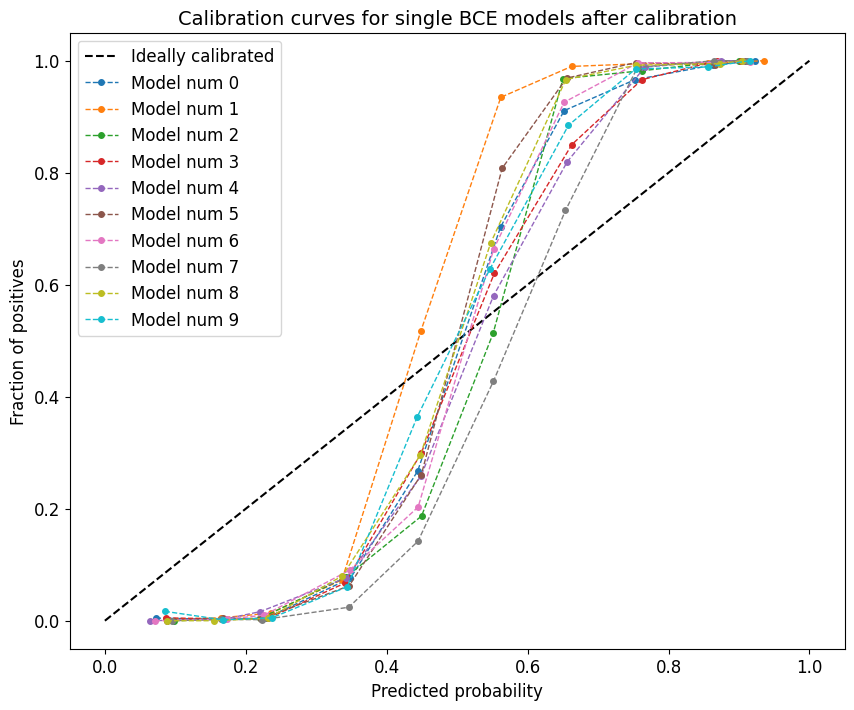

In [7]:
title = "Calibration curves for single BCE models after calibration"

calibrate_all_models_in_ensemble(ens_bce, test_dataloader, verbose=True, max_iter=200)

plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title)

### Metrics for calibrated ensemble

In [5]:
threshold_number = 5
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cpu",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  5%|▍         | 1/21 [00:00<00:02,  9.44it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.11it/s]


TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 101, FP: 215, FN: 0, TP: 1021, DELAY:0.0014958863612264395, FP_DELAY:9.09872817993164, COVER: 0.9734301803590849
TN: 170, FP: 19, FN: 6, TP: 1142, DELAY:0.05609573796391487, FP_DELAY:10.930440902709961, COVER: 0.9929626949291704
TN: 171, FP: 2, FN: 29, TP: 1135, DELAY:0.44353029131889343, FP_DELAY:11.246073722839355, COVER: 0.9763743897019639
TN: 172, FP: 0, FN: 119, TP: 1046, DELAY:1.8092745542526245, FP_DELAY:11.725504875183105, COVER: 0.877572565584238
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 44.9968
Time to FA 10.9304, delay detection 0.0561 for best-F1 threshold: 0.5
TN 170, FP 19, FN 6, TP 1142 for best-F1 threshold: 0.5
Max F1 0.9892: for best-F1 threshold 0.5
COVER 0.993: for best-F1 threshold 0.5
Max COVER 0.993: for threshold 0.5
Max F1 with margi

In [6]:
# wasserstein
threshold_list = np.linspace(0, 1, 10)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

 10%|▉         | 2/21 [00:00<00:01, 16.20it/s]

Collectting model's outputs


  0%|          | 0/10 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.4444444444444444
AUDC: 0.0, Time to FA: 11.2109, DD: 1.0942, F1: 0.9741, Cover: 0.9146, Max Cover: 0.9146
Max F1 with margin 1: 0.9627
Max F1 with margin 2: 0.9677
Max F1 with margin 4: 0.9723
window_size = 1, anchor_window_type = prev


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.3333333333333333
AUDC: 0.0, Time to FA: 11.2296, DD: 1.1376, F1: 0.9714, Cover: 0.9162, Max Cover: 0.9162
Max F1 with margin 1: 0.9668
Max F1 with margin 2: 0.97
Max F1 with margin 4: 0.9704
window_size = 2, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.3333333333333333
AUDC: 0.0, Time to FA: 11.2184, DD: 1.1376, F1: 0.9758, Cover: 0.9101, Max Cover: 0.9101
Max F1 with margin 1: 0.9317
Max F1 with margin 2: 0.9691
Max F1 with margin 4: 0.9709
window_size = 2, anchor_window_type = prev


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.3333333333333333
AUDC: 0.0, Time to FA: 11.3411, DD: 1.2087, F1: 0.9736, Cover: 0.9127, Max Cover: 0.9127
Max F1 with margin 1: 0.9356
Max F1 with margin 2: 0.97
Max F1 with margin 4: 0.9718
window_size = 3, anchor_window_type = start


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 11.1159, DD: 1.1548, F1: 0.9701, Cover: 0.9039, Max Cover: 0.9039
Max F1 with margin 1: 0.9132
Max F1 with margin 2: 0.9493
Max F1 with margin 4: 0.9655
window_size = 3, anchor_window_type = prev


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Results for best threshold = 0.2222222222222222
AUDC: 0.0, Time to FA: 11.2289, DD: 1.1975, F1: 0.975, Cover: 0.9076, Max Cover: 0.9076
Max F1 with margin 1: 0.9184
Max F1 with margin 2: 0.9548
Max F1 with margin 4: 0.9695


In [14]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cpu",
);

  5%|▍         | 1/21 [00:00<00:02,  9.27it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 16.03it/s]


Half-window: 1
CP stds list:
Mean = 0.03981080801143759, number is 1141
Normal stds list:
Mean = 0.02655655362334765, number is 1304
p_val analytical = 8.685884549202846e-30, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.037802723253522914, number is 1141
Normal stds list:
Mean = 0.026328707810885005, number is 1268
p_val analytical = 7.003568283072527e-22, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.03559003986734946, number is 1141
Normal stds list:
Mean = 0.026202670583087537, number is 1224
p_val analytical = 1.896309390822877e-14, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------


In [7]:
# cusums
ens_bce.args["cusum"]["normal_sigma"] = 0.0266
ens_bce.args["cusum"]["cp_sigma"] = 0.0398
ens_bce.args["cusum"]["half_window"] = 1

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=10,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cpu",
    verbose=True,
    min_th_quant=0.1,
    max_th_quant=0.9,
)

 10%|▉         | 2/21 [00:00<00:01, 13.24it/s]

Collectting model's outputs


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 89.43309783935547)


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 9.937010871039497
AUDC: 0.0, Time to FA: 10.4697, DD: 0.5355, F1: 0.9774, Cover: 0.9844, Max Cover: 0.9844
Max F1 with margin 1: 0.9652
Max F1 with margin 2: 0.9693
Max F1 with margin 4: 0.9742
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 6925.26025390625)


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 9.9387, DD: 0.0853, F1: 0.9902, Cover: 0.9946, Max Cover: 0.9946
Max F1 with margin 1: 0.9867
Max F1 with margin 2: 0.9898
Max F1 with margin 4: 0.991
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 2839254.25)


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 11.0262, DD: 0.0935, F1: 0.9909, Cover: 0.9938, Max Cover: 0.9938
Max F1 with margin 1: 0.9865
Max F1 with margin 2: 0.9896
Max F1 with margin 4: 0.9914
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = False
Threshold range: (0.004160822369158268, 7020.97314453125)


  0%|          | 0/10 [00:00<?, ?it/s]

Results for best threshold = 780.1118256789115
AUDC: 0.0, Time to FA: 9.9955, DD: 0.893, F1: 0.9833, Cover: 0.924, Max Cover: 0.924
Max F1 with margin 1: 0.96
Max F1 with margin 2: 0.9771
Max F1 with margin 4: 0.9811
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = True
Threshold range: (0.0010872380807995796, 2384089.5)


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

Results for best threshold = 264898.83429976716
AUDC: 0.0, Time to FA: 12.721, DD: 3.5168, F1: 0.8634, Cover: 0.7845, Max Cover: 0.7845
Max F1 with margin 1: 0.0744
Max F1 with margin 2: 0.6147
Max F1 with margin 4: 0.813


In [8]:
res_cusums

{('old',
  True): ((0.0,
   10.469708442687988,
   0.5355272889137268,
   0.9773519163763066,
   0.9843680969858142,
   0.9843680969858142,
   {1: 0.9651828999559278,
    2: 0.9692712906057945,
    4: 0.9742245522062036}), 9.937010871039497),
 ('correct',
  False): ((0.0,
   9.938668251037598,
   0.08526551723480225,
   0.990183525394793,
   0.9945980223401935,
   0.9945980223401935,
   {1: 0.9867237687366167, 2: 0.9897523484201537, 4: 0.991044776119403}), 0.0),
 ('correct',
  True): ((0.0,
   11.026178359985352,
   0.09349289536476135,
   0.9909208819714657,
   0.9937977231629311,
   0.9937977231629311,
   {1: 0.9865392965696917,
    2: 0.9896103896103896,
    4: 0.9913569576490925}), 0.0),
 ('new_criteria',
  False): ((0.0,
   9.995512008666992,
   0.893044114112854,
   0.9832546157148991,
   0.9239538981836107,
   0.9239538981836107,
   {1: 0.9600351339481774,
    2: 0.9771058315334773,
    4: 0.9810671256454389}), 780.1118256789115),
 ('new_criteria',
  True): ((0.0,
   12.72101688

In [14]:
**res_cusums

SyntaxError: invalid syntax (3550464427.py, line 1)

# BCE-SGLD HAR

In [23]:
model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [24]:
path_to_models_folder = "saved_models/bce/human_activity/sgld_adam"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

100%|██████████| 21/21 [00:00<00:00, 27.66it/s]


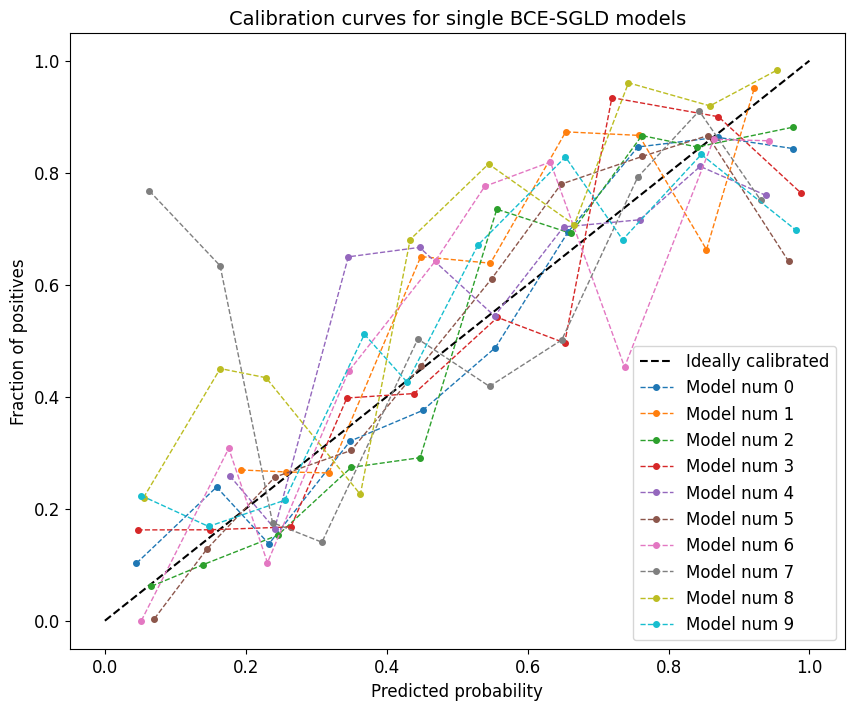

In [19]:
title = "Calibration curves for single BCE-SGLD models"

plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title);

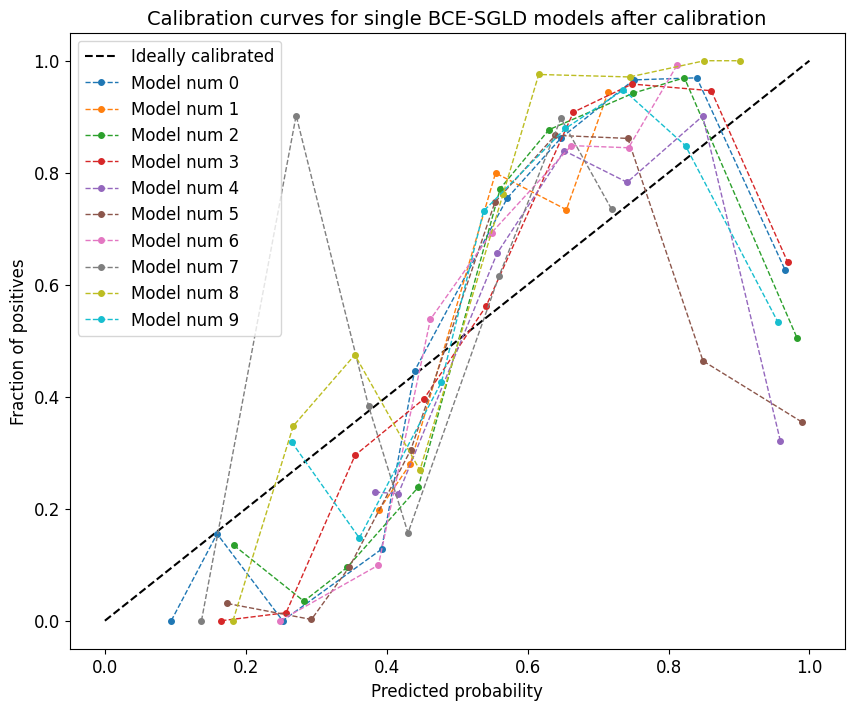

In [25]:
title = "Calibration curves for single BCE-SGLD models after calibration"

calibrate_all_models_in_ensemble(ens_bce, test_dataloader, verbose=False)
plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title)

In [26]:
# calibrated ensemble MEAN
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cpu",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

 10%|▉         | 2/21 [00:00<00:01, 12.47it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.72it/s]


TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 

In [27]:
# wasserstein
threshold_list = np.linspace(0, 1, 50)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
    window_size_list=[1, 2, 3],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

 14%|█▍        | 3/21 [00:00<00:00, 20.54it/s]

Collectting model's outputs


  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.04081632653061224
AUDC: 0.0, Time to FA: 8.7046, DD: 1.1242, F1: 0.8937, Cover: 0.862, Max Cover: 0.862
Max F1 with margin 1: 0.7667
Max F1 with margin 2: 0.8737
Max F1 with margin 4: 0.888
window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.04081632653061224
AUDC: 0.0, Time to FA: 9.4368, DD: 1.3882, F1: 0.8819, Cover: 0.859, Max Cover: 0.859
Max F1 with margin 1: 0.7798
Max F1 with margin 2: 0.8727
Max F1 with margin 4: 0.881
window_size = 2, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.04081632653061224
AUDC: 0.0, Time to FA: 9.4727, DD: 1.4757, F1: 0.8987, Cover: 0.8365, Max Cover: 0.8365
Max F1 with margin 1: 0.6032
Max F1 with margin 2: 0.8355
Max F1 with margin 4: 0.8926
window_size = 2, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.04081632653061224
AUDC: 0.0, Time to FA: 9.6948, DD: 1.5363, F1: 0.8959, Cover: 0.8394, Max Cover: 0.8394
Max F1 with margin 1: 0.6153
Max F1 with margin 2: 0.8395
Max F1 with margin 4: 0.894
window_size = 3, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.04081632653061224
AUDC: 0.0, Time to FA: 9.9162, DD: 1.7696, F1: 0.9005, Cover: 0.8153, Max Cover: 0.8153
Max F1 with margin 1: 0.4778
Max F1 with margin 2: 0.7807
Max F1 with margin 4: 0.8843
window_size = 3, anchor_window_type = prev


100%|██████████| 50/50 [01:57<00:00,  2.35s/it]

Results for best threshold = 0.04081632653061224
AUDC: 0.0, Time to FA: 10.2027, DD: 1.8257, F1: 0.9003, Cover: 0.8229, Max Cover: 0.8229
Max F1 with margin 1: 0.4715
Max F1 with margin 2: 0.7975
Max F1 with margin 4: 0.8898


In [28]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cpu",
);

 10%|▉         | 2/21 [00:00<00:01, 16.05it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 17.59it/s]


Half-window: 1
CP stds list:
Mean = 0.0683335250245177, number is 1141
Normal stds list:
Mean = 0.06339809837739663, number is 1304
p_val analytical = 1.6455352005186954e-06, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.07171445315431127, number is 1141
Normal stds list:
Mean = 0.06352026247028673, number is 1268
p_val analytical = 6.380892581282089e-15, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.07284651783202742, number is 1141
Normal stds list:
Mean = 0.06377117540778629, number is 1224
p_val analytical = 5.534329795255719e-17, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------


In [29]:
# cusums
ens_bce.args["cusum"]["normal_sigma"] = 0.0635
ens_bce.args["cusum"]["cp_sigma"] = 0.0717
ens_bce.args["cusum"]["half_window"] = 2

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=300,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cpu",
    verbose=True,
    min_th_quant=0.1,
    max_th_quant=0.9,
)

 10%|▉         | 2/21 [00:00<00:01, 15.22it/s]

Collectting model's outputs


  0%|          | 0/300 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 2.4296882152557373)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 0.9344954674060527
AUDC: 0.0, Time to FA: 9.7943, DD: 0.8953, F1: 0.9278, Cover: 0.9346, Max Cover: 0.9346
Max F1 with margin 1: 0.9031
Max F1 with margin 2: 0.917
Max F1 with margin 4: 0.9245
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 236.06492614746094)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 41.05476976477581
AUDC: 0.0, Time to FA: 9.4705, DD: 2.2902, F1: 0.8758, Cover: 0.8429, Max Cover: 0.8429
Max F1 with margin 1: 0.6641
Max F1 with margin 2: 0.7483
Max F1 with margin 4: 0.8479
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 100.07823944091797)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 13.053683405337125
AUDC: 0.0, Time to FA: 9.2917, DD: 1.8115, F1: 0.887, Cover: 0.8697, Max Cover: 0.8697
Max F1 with margin 1: 0.7218
Max F1 with margin 2: 0.8195
Max F1 with margin 4: 0.8707
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = False
Threshold range: (0.5530215501785278, 262.33892822265625)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 23.31701343474181
AUDC: 0.0, Time to FA: 10.2064, DD: 2.0636, F1: 0.867, Cover: 0.8536, Max Cover: 0.8536
Max F1 with margin 1: 0.6967
Max F1 with margin 2: 0.7881
Max F1 with margin 4: 0.8481
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = True
Threshold range: (0.5434824824333191, 106.15803527832031)


100%|██████████| 300/300 [02:19<00:00,  2.15it/s]

Results for best threshold = 9.020904780430937
AUDC: 0.0, Time to FA: 9.8325, DD: 1.7457, F1: 0.8706, Cover: 0.8705, Max Cover: 0.8705
Max F1 with margin 1: 0.7297
Max F1 with margin 2: 0.8175
Max F1 with margin 4: 0.866


# BCE Explosion

In [3]:
model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [4]:
path_to_models_folder = "saved_models/bce/explosion/layer_norm/train_anomaly_num_155"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


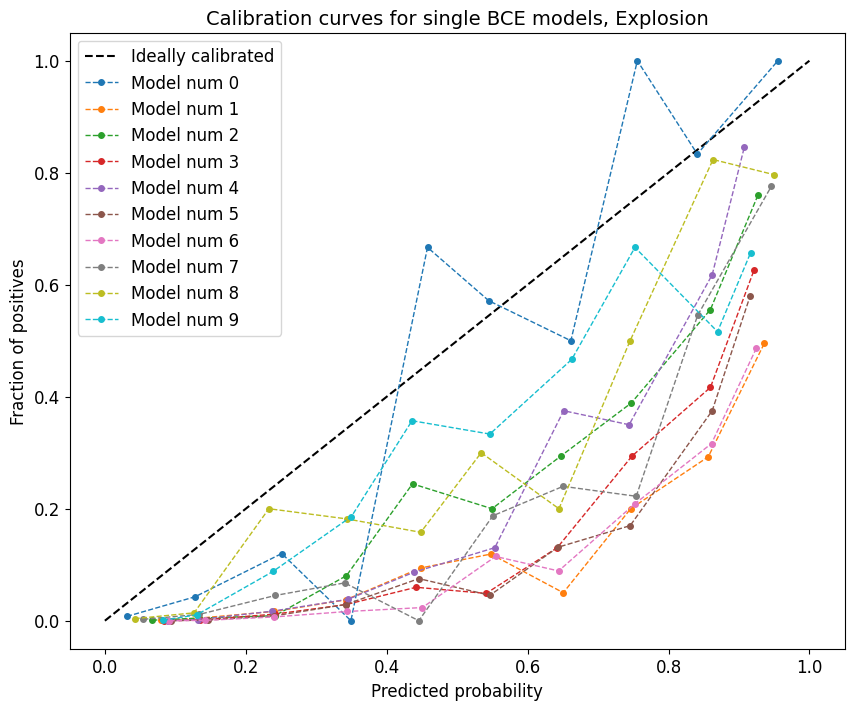

In [ ]:
title = "Calibration curves for single BCE models, Explosion"

plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda"
);

## Set temperature manually

In [6]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


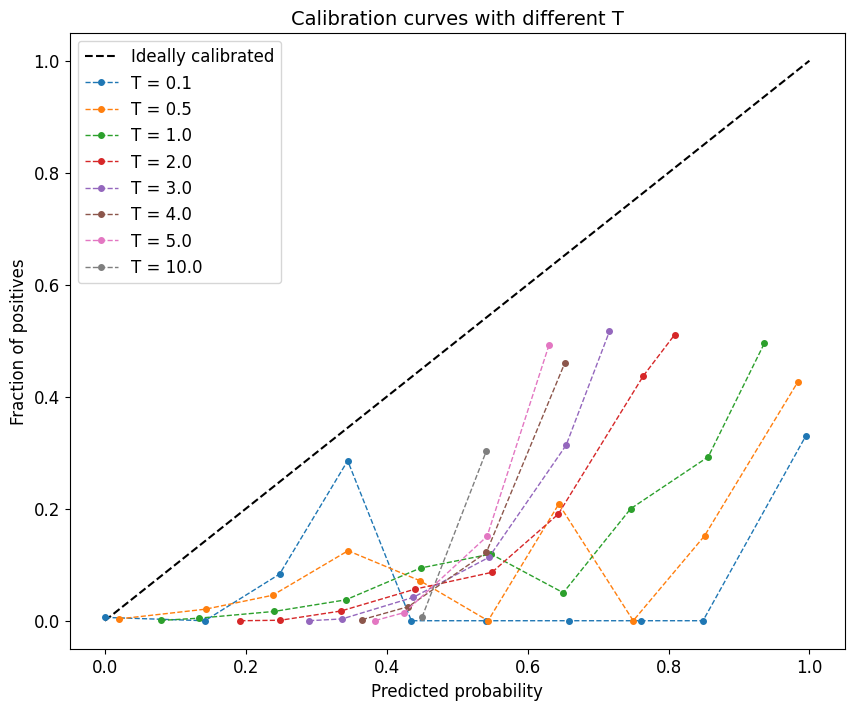

In [26]:
single_model = ens_bce.models_list[1]

x_ideal = np.linspace(0, 1, 20)

temperature_list = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]

plt.figure(figsize=(10, 8))
plt.plot(x_ideal, x_ideal, linestyle="--", label="Ideally calibrated", c="black")

for temp in temperature_list:
    single_model.model.temperature = temp

    test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
        single_model,
        test_dataloader,
        model_type=model_type,
        device="cuda",
        verbose=True,
    )

    test_out_flat = torch.vstack(test_out_bank).flatten()
    test_labels_flat = torch.vstack(test_labels_bank).flatten()

    prob_true, prob_pred = calibration_curve(test_labels_flat, test_out_flat, n_bins=10)

    plt.plot(
        prob_pred,
        prob_true,
        linestyle="--",
        marker="o",
        markersize=4,
        linewidth=1,
        label=f"T = {temp}",
    )

plt.title("Calibration curves with different T", fontsize=14)
plt.xlabel("Predicted probability", fontsize=12)
plt.ylabel("Fraction of positives", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

## Calibrate with Temperature scaling

In [14]:
uncalibrate_all_models_in_ensemble(ens_bce)

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]

Before temperature - NLL: 0.259, ECE: 0.132
Optimal temperature: 1.484
After temperature - NLL: 0.276, ECE: 0.166


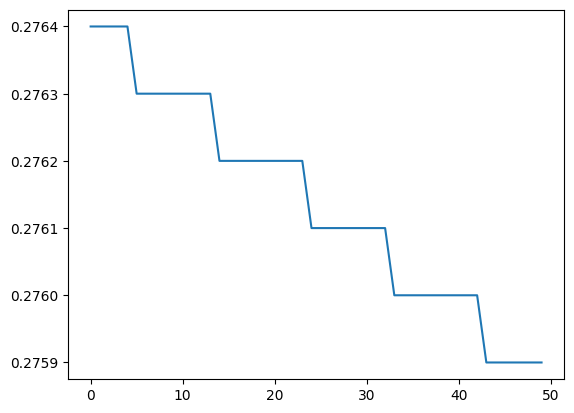

In [13]:
preprocessor = ens_bce.models_list[0].extractor
core_model = ens_bce.models_list[0].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=50,
    verbose=True,
    device="cuda:1",
    return_loss=True,
)

plt.plot(loss_history)

100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


Before temperature - NLL: 0.242, ECE: 0.130
Optimal temperature: 1.290
After temperature - NLL: 0.256, ECE: 0.152


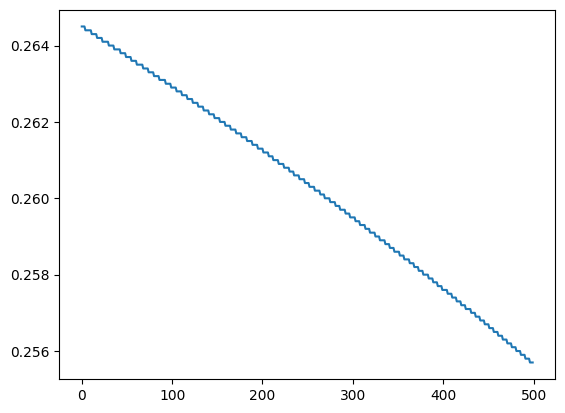

In [15]:
preprocessor = ens_bce.models_list[0].extractor
core_model = ens_bce.models_list[0].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=500,
    verbose=True,
    device="cuda:1",
    return_loss=True,
)

plt.plot(loss_history)

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


Before temperature - NLL: 0.236, ECE: 0.131
Optimal temperature: 0.999
After temperature - NLL: 0.236, ECE: 0.131


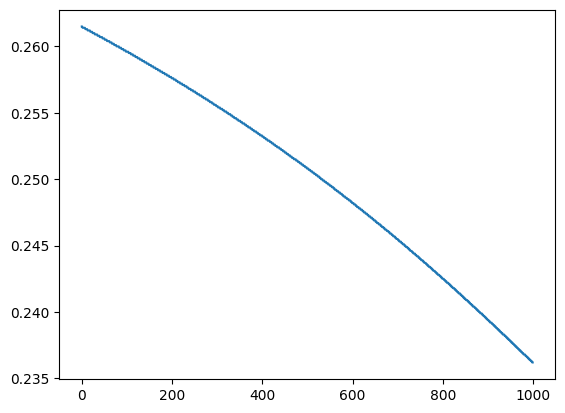

In [17]:
uncalibrate_all_models_in_ensemble(ens_bce)

preprocessor = ens_bce.models_list[0].extractor
core_model = ens_bce.models_list[0].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda:1",
    return_loss=True,
)

plt.plot(loss_history);

100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


Before temperature - NLL: 0.246, ECE: 0.128
Optimal temperature: 0.677
After temperature - NLL: 0.237, ECE: 0.087


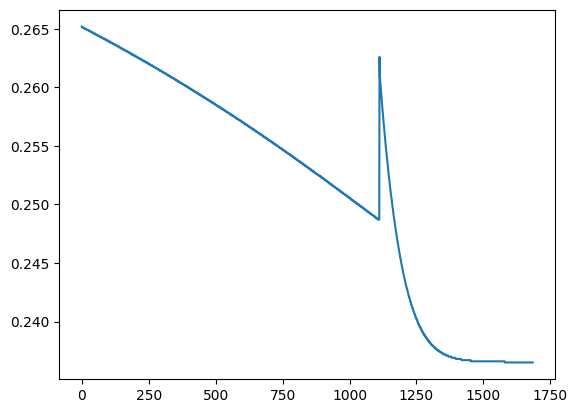

In [18]:
uncalibrate_all_models_in_ensemble(ens_bce)

preprocessor = ens_bce.models_list[0].extractor
core_model = ens_bce.models_list[0].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=10000,
    verbose=True,
    device="cuda:1",
    return_loss=True,
)

plt.plot(loss_history);

### Calibration params

100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.259, ECE: 0.132


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.151
After temperature - NLL: 0.264, ECE: 0.145


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.379, ECE: 0.150


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.551
After temperature - NLL: 0.365, ECE: 0.181


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.250, ECE: 0.136


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: -2016.135
After temperature - NLL: 0.694, ECE: 0.473


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.319, ECE: 0.146


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.059
After temperature - NLL: 0.319, ECE: 0.150


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


Before temperature - NLL: 0.254, ECE: 0.135


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: -2032.025
After temperature - NLL: 0.694, ECE: 0.465


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


Before temperature - NLL: 0.322, ECE: 0.150


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 0.989
After temperature - NLL: 0.322, ECE: 0.149


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.379, ECE: 0.155
Optimal temperature: 1.500
After temperature - NLL: 0.367, ECE: 0.183


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


Before temperature - NLL: 0.278, ECE: 0.139


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 0.841
After temperature - NLL: 0.276, ECE: 0.121


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.238, ECE: 0.129


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.050
After temperature - NLL: 0.241, ECE: 0.133


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Before temperature - NLL: 0.246, ECE: 0.134


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: -645433.188
After temperature - NLL: 0.693, ECE: 0.477
Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


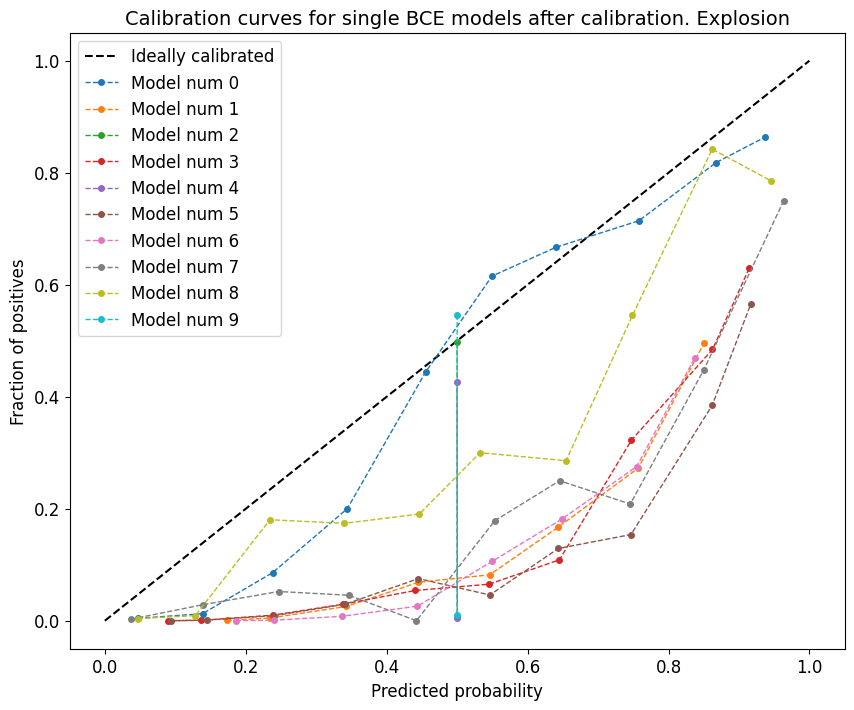

In [5]:
preprocessor = ens_bce.models_list[0].extractor

uncalibrate_all_models_in_ensemble(ens_bce)
calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    preprocessor=preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda",
)

title = "Calibration curves for single BCE models after calibration. Explosion"
plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
)

100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.259, ECE: 0.132


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.151
After temperature - NLL: 0.264, ECE: 0.145


100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


Before temperature - NLL: 0.379, ECE: 0.150


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.551
After temperature - NLL: 0.365, ECE: 0.181


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Before temperature - NLL: 0.250, ECE: 0.136


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: -2016.135
After temperature - NLL: 0.694, ECE: 0.473


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.319, ECE: 0.146


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.059
After temperature - NLL: 0.319, ECE: 0.150


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.254, ECE: 0.135


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: -2032.025
After temperature - NLL: 0.694, ECE: 0.465


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.322, ECE: 0.150


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 0.989
After temperature - NLL: 0.322, ECE: 0.149


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.379, ECE: 0.155
Optimal temperature: 1.500
After temperature - NLL: 0.367, ECE: 0.183


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.278, ECE: 0.139


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 0.841
After temperature - NLL: 0.276, ECE: 0.121


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.238, ECE: 0.129


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.050
After temperature - NLL: 0.241, ECE: 0.133


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Before temperature - NLL: 0.246, ECE: 0.134


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: -645433.188
After temperature - NLL: 0.693, ECE: 0.477
Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


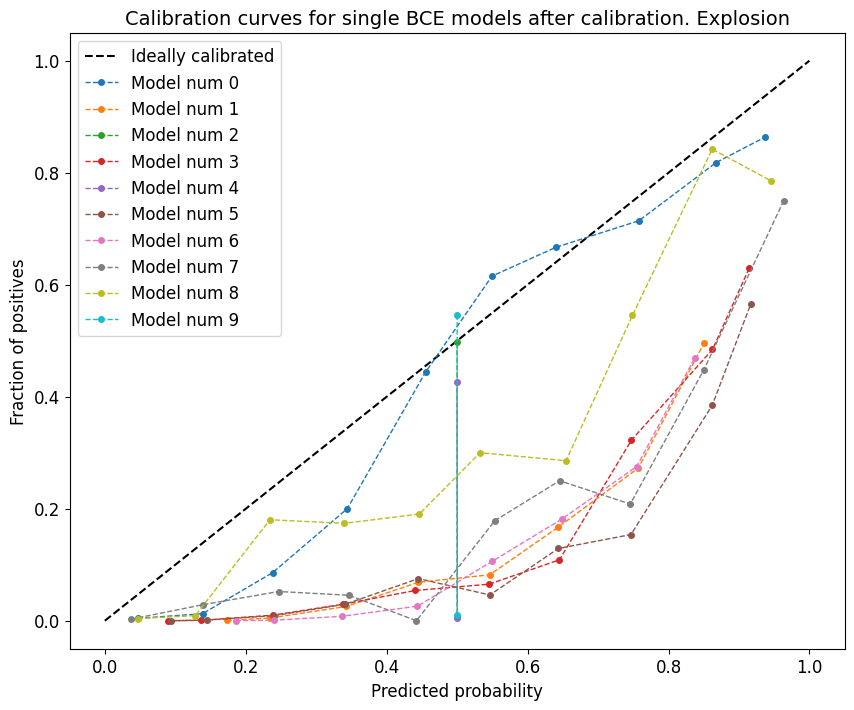

In [6]:
uncalibrate_all_models_in_ensemble(ens_bce)

preprocessor = ens_bce.models_list[0].extractor
calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    preprocessor=preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda",
)

title = "Calibration curves for single BCE models after calibration. Explosion"
plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
)

100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.056, ECE: 0.009


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.423
After temperature - NLL: 0.049, ECE: 0.003


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


Before temperature - NLL: 0.275, ECE: 0.044


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.542
After temperature - NLL: 0.240, ECE: 0.009


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.102, ECE: 0.013


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.120
After temperature - NLL: 0.101, ECE: 0.007


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Before temperature - NLL: 0.194, ECE: 0.029


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.303
After temperature - NLL: 0.183, ECE: 0.008


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.119, ECE: 0.014


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 0.994
After temperature - NLL: 0.119, ECE: 0.013


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


Before temperature - NLL: 0.177, ECE: 0.013


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.065
After temperature - NLL: 0.177, ECE: 0.010


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.291, ECE: 0.047


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.469
After temperature - NLL: 0.262, ECE: 0.007


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Before temperature - NLL: 0.122, ECE: 0.022


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.335
After temperature - NLL: 0.114, ECE: 0.017


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.072, ECE: 0.012


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.323
After temperature - NLL: 0.066, ECE: 0.005


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.082, ECE: 0.007


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.057
After temperature - NLL: 0.082, ECE: 0.004
Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


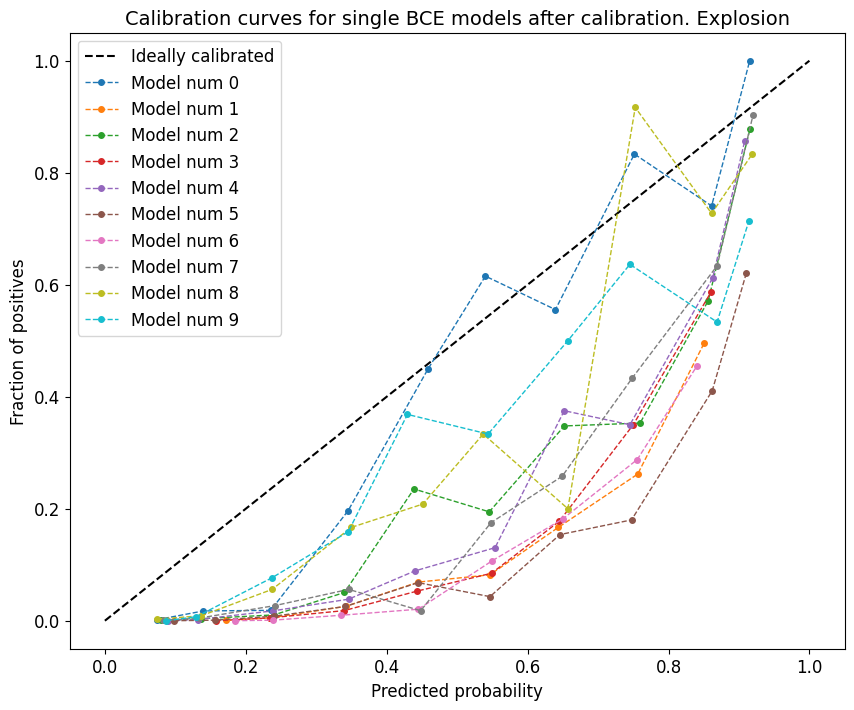

In [6]:
preprocessor = ens_bce.models_list[0].extractor

uncalibrate_all_models_in_ensemble(ens_bce)

calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    preprocessor=preprocessor,
    lr=1e-2,
    max_iter=10000,
    verbose=True,
    device="cuda",
)

title = "Calibration curves for single BCE models after calibration. Explosion"
plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
)

## Metrics

In [7]:
temperature_list = [
    1.423,
    1.542,
    1.120,
    1.303,
    0.994,
    1.065,
    1.469,
    1.335,
    1.323,
    1.057,
]

manually_calibrate_all_models_in_ensemble(ens_bce, temperature_list)

In [8]:
# calibrated ensemble MEAN
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cuda",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:39<00:00,  7.96s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0

In [9]:
# wasserstein
threshold_list = np.linspace(0, 1, 100)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    device="cuda",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/100 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.42424242424242425
AUDC: 0.0, Time to FA: 15.5714, DD: 0.127, F1: 0.7273, Cover: 0.9833, Max Cover: 0.9833
Max F1 with margin 1: 0.3846
Max F1 with margin 2: 0.5517
Max F1 with margin 4: 0.7273
window_size = 1, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.19191919191919193
AUDC: 0.0, Time to FA: 15.6603, DD: 0.1143, F1: 0.7407, Cover: 0.9882, Max Cover: 0.9882
Max F1 with margin 1: 0.64
Max F1 with margin 2: 0.64
Max F1 with margin 4: 0.7407
window_size = 2, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.393939393939394
AUDC: 0.0, Time to FA: 15.5683, DD: 0.1333, F1: 0.7273, Cover: 0.9814, Max Cover: 0.9814
Max F1 with margin 1: 0.25
Max F1 with margin 2: 0.5517
Max F1 with margin 4: 0.7273
window_size = 2, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.23232323232323235
AUDC: 0.0, Time to FA: 15.619, DD: 0.1238, F1: 0.7586, Cover: 0.9854, Max Cover: 0.9854
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586
window_size = 3, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.393939393939394
AUDC: 0.0, Time to FA: 15.6095, DD: 0.1556, F1: 0.7097, Cover: 0.9815, Max Cover: 0.9815
Max F1 with margin 1: 0.0952
Max F1 with margin 2: 0.4615
Max F1 with margin 4: 0.6207
window_size = 3, anchor_window_type = prev


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Results for best threshold = 0.26262626262626265
AUDC: 0.0, Time to FA: 15.6317, DD: 0.1365, F1: 0.7857, Cover: 0.9841, Max Cover: 0.9841
Max F1 with margin 1: 0.3
Max F1 with margin 2: 0.64
Max F1 with margin 4: 0.8276


In [10]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cuda",
);

  0%|          | 0/20 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 20/20 [02:42<00:00,  8.10s/it]


Half-window: 1
CP stds list:
Mean = 0.09998644515872002, number is 15
Normal stds list:
Mean = 0.06770148310976423, number is 314
p_val analytical = 0.09401892953998207, p_val permutational = 0.17888211178882113
No conclusion
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.09834550519784292, number is 15
Normal stds list:
Mean = 0.06748728601226381, number is 314
p_val analytical = 0.0997495795760982, p_val permutational = 0.18038196180381963
No conclusion
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.09839345266421635, number is 15
Normal stds list:
Mean = 0.06728555215819246, number is 314
p_val analytical = 0.08774611211628391, p_val permutational = 0.1591840815918408
No conclusion
--------------------------------------------------


In [13]:
ens_bce.models_list[0].model.temperature

1.423

In [17]:
# cusums
ens_bce.args["cusum"] = {}
ens_bce.args["cusum"]["normal_sigma"] = 0.068
ens_bce.args["cusum"]["cp_sigma"] = 0.100
ens_bce.args["cusum"]["half_window"] = 1

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=300,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cuda",
    verbose=True,
    min_th_quant=0,
    max_th_quant=1,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/300 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 15.087215423583984)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 5.3991038472357396
AUDC: 0.0, Time to FA: 15.7651, DD: 0.146, F1: 0.7692, Cover: 0.9915, Max Cover: 0.9915
Max F1 with margin 1: 0.6667
Max F1 with margin 2: 0.6667
Max F1 with margin 4: 0.7692
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 770.2813720703125)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 82.43814015468227
AUDC: 0.0, Time to FA: 15.6286, DD: 0.1746, F1: 0.6875, Cover: 0.9818, Max Cover: 0.9818
Max F1 with margin 1: 0.3846
Max F1 with margin 2: 0.4444
Max F1 with margin 4: 0.6452
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 5926.42822265625)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 19.820830176107858
AUDC: 0.0, Time to FA: 15.5905, DD: 0.0984, F1: 0.75, Cover: 0.9873, Max Cover: 0.9873
Max F1 with margin 1: 0.5714
Max F1 with margin 2: 0.5714
Max F1 with margin 4: 0.75
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = False
Threshold range: (0.0, 469.7501525878906)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 84.83782019981972
AUDC: 0.0, Time to FA: 15.6095, DD: 0.1714, F1: 0.7059, Cover: 0.9814, Max Cover: 0.9814
Max F1 with margin 1: 0.3704
Max F1 with margin 2: 0.4828
Max F1 with margin 4: 0.6667
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = True
Threshold range: (0.0, 6157.92919921875)


100%|██████████| 300/300 [03:11<00:00,  1.56it/s]

Results for best threshold = 102.97540466920987
AUDC: 0.0, Time to FA: 15.7714, DD: 0.1841, F1: 0.75, Cover: 0.9863, Max Cover: 0.9863
Max F1 with margin 1: 0.5714
Max F1 with margin 2: 0.5714
Max F1 with margin 4: 0.6957


# BCE Road Accidents

In [3]:
model_type = "seq2seq"

experiments_name = "road_accidents"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [4]:
path_to_models_folder = "saved_models/bce/road_accidents/layer_norm/ens_1"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

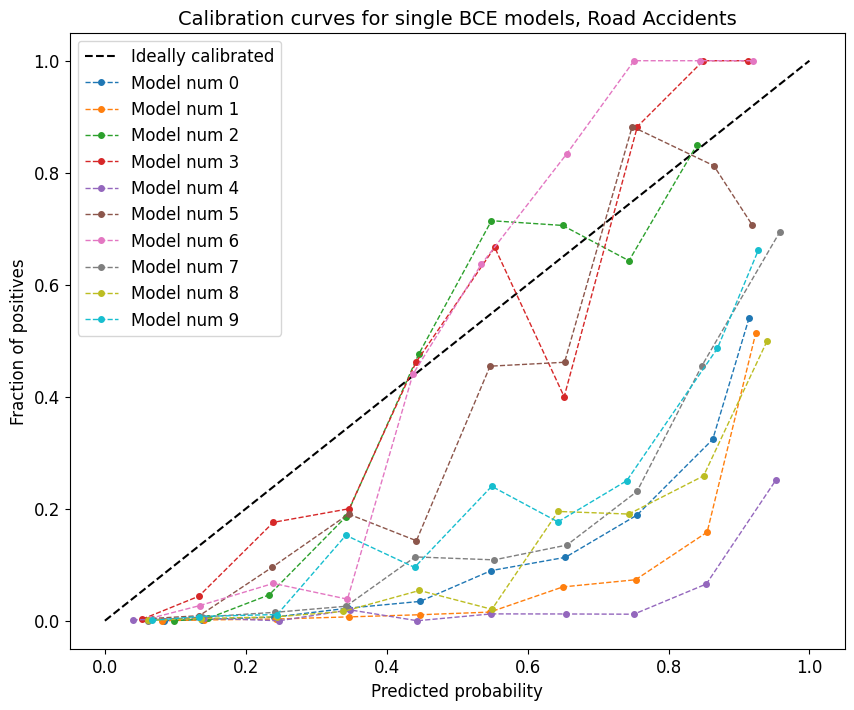

In [6]:
title = "Calibration curves for single BCE models, Road Accidents"

plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
);

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Before temperature - NLL: 0.107, ECE: 0.024
Optimal temperature: 0.855
After temperature - NLL: 0.104, ECE: 0.011


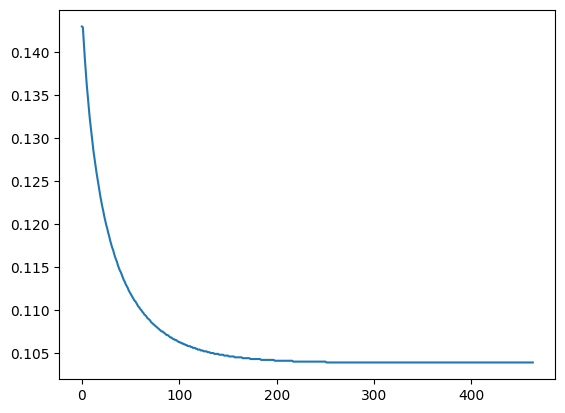

In [9]:
preprocessor = ens_bce.models_list[0].extractor
core_model = ens_bce.models_list[0].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda",
    return_loss=True,
)

plt.plot(loss_history)

100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


Before temperature - NLL: 0.395, ECE: 0.081
Optimal temperature: 2.340
After temperature - NLL: 0.260, ECE: 0.051


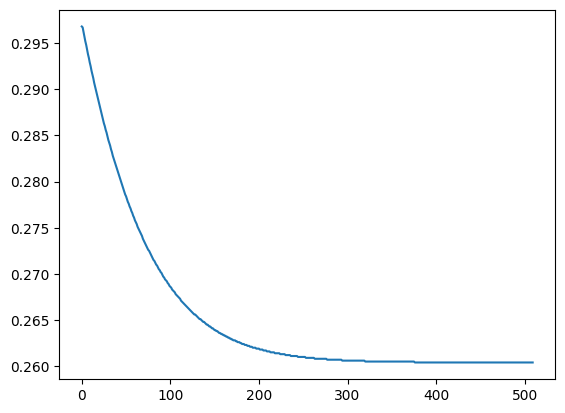

In [10]:
preprocessor = ens_bce.models_list[4].extractor
core_model = ens_bce.models_list[4].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda",
    return_loss=True,
)

plt.plot(loss_history)

100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Before temperature - NLL: 0.067, ECE: 0.009
Optimal temperature: 1.211
After temperature - NLL: 0.064, ECE: 0.003


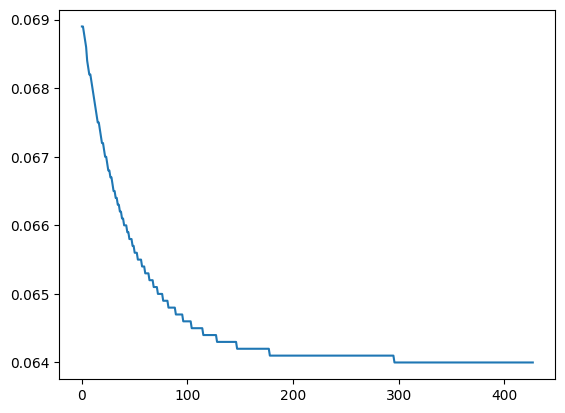

In [11]:
preprocessor = ens_bce.models_list[6].extractor
core_model = ens_bce.models_list[6].model

_, loss_history = calibrate_single_model(
    core_model,
    test_dataloader,
    preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda",
    return_loss=True,
)

plt.plot(loss_history)

100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Before temperature - NLL: 0.118, ECE: 0.013


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.114
After temperature - NLL: 0.117, ECE: 0.006


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.219, ECE: 0.035


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.291
After temperature - NLL: 0.209, ECE: 0.024


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


Before temperature - NLL: 0.062, ECE: 0.010


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 0.918
After temperature - NLL: 0.061, ECE: 0.005


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.063, ECE: 0.010


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.305
After temperature - NLL: 0.057, ECE: 0.003


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Before temperature - NLL: 0.395, ECE: 0.080


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 2.340
After temperature - NLL: 0.261, ECE: 0.050


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.059, ECE: 0.008


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.158
After temperature - NLL: 0.057, ECE: 0.003


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Before temperature - NLL: 0.068, ECE: 0.008


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.212
After temperature - NLL: 0.065, ECE: 0.002


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.076, ECE: 0.005


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.083
After temperature - NLL: 0.076, ECE: 0.004


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.114, ECE: 0.015


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.278
After temperature - NLL: 0.107, ECE: 0.004


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.058, ECE: 0.006


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.109
After temperature - NLL: 0.057, ECE: 0.002
Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


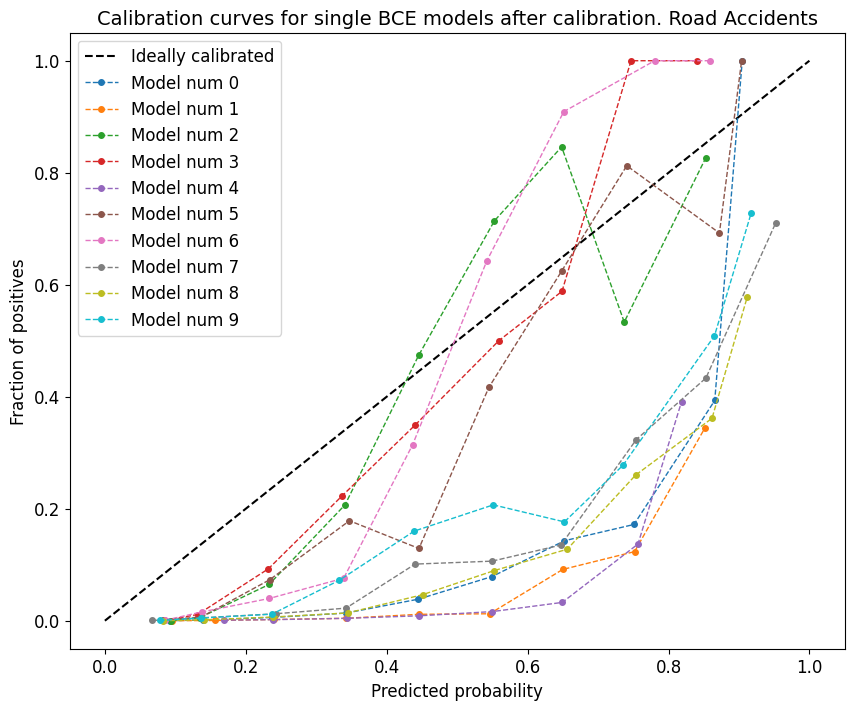

In [12]:
# calibrate all the models
preprocessor = ens_bce.models_list[0].extractor

uncalibrate_all_models_in_ensemble(ens_bce)
calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    preprocessor=preprocessor,
    lr=1e-2,
    max_iter=1000,
    verbose=True,
    device="cuda",
)

title = "Calibration curves for single BCE models after calibration. Road Accidents"
plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
)

In [13]:
temperature_list = [
    1.114,
    1.291,
    0.918,
    1.305,
    2.340,
    1.158,
    1.212,
    1.083,
    1.278,
    1.109,
]

manually_calibrate_all_models_in_ensemble(ens_bce, temperature_list)

In [14]:
# calibrated ensemble MEAN
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cuda",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:40<00:00,  8.01s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0

In [15]:
# wasserstein
threshold_list = np.linspace(0, 1, 100)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    device="cuda",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/100 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.43434343434343436
AUDC: 0.0, Time to FA: 15.654, DD: 0.181, F1: 0.7333, Cover: 0.9828, Max Cover: 0.9828
Max F1 with margin 1: 0.3478
Max F1 with margin 2: 0.48
Max F1 with margin 4: 0.6429
window_size = 1, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.15151515151515152
AUDC: 0.0, Time to FA: 15.619, DD: 0.1111, F1: 0.6897, Cover: 0.9867, Max Cover: 0.9867
Max F1 with margin 1: 0.5926
Max F1 with margin 2: 0.5926
Max F1 with margin 4: 0.6897
window_size = 2, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.393939393939394
AUDC: 0.0, Time to FA: 15.6063, DD: 0.1746, F1: 0.7097, Cover: 0.9805, Max Cover: 0.9805
Max F1 with margin 1: 0.1818
Max F1 with margin 2: 0.4615
Max F1 with margin 4: 0.6207
window_size = 2, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.25252525252525254
AUDC: 0.0, Time to FA: 15.6635, DD: 0.1302, F1: 0.7143, Cover: 0.9865, Max Cover: 0.9865
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586
window_size = 3, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.38383838383838387
AUDC: 0.0, Time to FA: 15.6159, DD: 0.1841, F1: 0.7097, Cover: 0.9798, Max Cover: 0.9798
Max F1 with margin 1: 0.0952
Max F1 with margin 2: 0.4
Max F1 with margin 4: 0.6207
window_size = 3, anchor_window_type = prev


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]

Results for best threshold = 0.22222222222222224
AUDC: 0.0, Time to FA: 15.5841, DD: 0.1175, F1: 0.75, Cover: 0.9834, Max Cover: 0.9834
Max F1 with margin 1: 0.3333
Max F1 with margin 2: 0.5714
Max F1 with margin 4: 0.75


In [16]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cuda",
);

  0%|          | 0/20 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 20/20 [02:42<00:00,  8.12s/it]


Half-window: 1
CP stds list:
Mean = 0.1365090325474739, number is 15
Normal stds list:
Mean = 0.07203428440721361, number is 314
p_val analytical = 0.01708099990963701, p_val permutational = 0.049295070492950704
Stds are not statistically equal
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.13216420660416286, number is 15
Normal stds list:
Mean = 0.07181592498591562, number is 314
p_val analytical = 0.02036679167996773, p_val permutational = 0.0496950304969503
Stds are not statistically equal
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.13214336906870205, number is 15
Normal stds list:
Mean = 0.07160574697836, number is 314
p_val analytical = 0.015907435634584632, p_val permutational = 0.042495750424957505
Stds are not statistically equal
--------------------------------------------------


In [17]:
# cusums
ens_bce.args["cusum"] = {}
ens_bce.args["cusum"]["normal_sigma"] = 0.0720
ens_bce.args["cusum"]["cp_sigma"] = 0.1365
ens_bce.args["cusum"]["half_window"] = 1

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=300,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cuda",
    verbose=True,
    min_th_quant=0,
    max_th_quant=1,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/300 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 10.621464729309082)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 4.227271915678196
AUDC: 0.0, Time to FA: 15.7683, DD: 0.1937, F1: 0.6667, Cover: 0.9876, Max Cover: 0.9876
Max F1 with margin 1: 0.4348
Max F1 with margin 2: 0.56
Max F1 with margin 4: 0.6154
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 655.8292846679688)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 135.99135668700356
AUDC: 0.0, Time to FA: 15.7016, DD: 0.2095, F1: 0.7143, Cover: 0.9814, Max Cover: 0.9814
Max F1 with margin 1: 0.1053
Max F1 with margin 2: 0.4348
Max F1 with margin 4: 0.6154
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 1045.4658203125)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 24.4757884354097
AUDC: 0.0, Time to FA: 15.7333, DD: 0.219, F1: 0.72, Cover: 0.9855, Max Cover: 0.9855
Max F1 with margin 1: 0.5455
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.5455
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = False
Threshold range: (0.0, 578.8192138671875)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 158.73971751541598
AUDC: 0.0, Time to FA: 15.7016, DD: 0.2254, F1: 0.7143, Cover: 0.9803, Max Cover: 0.9803
Max F1 with margin 1: 0.1053
Max F1 with margin 2: 0.2857
Max F1 with margin 4: 0.56
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = True
Threshold range: (0.0, 1059.4898681640625)


100%|██████████| 300/300 [03:15<00:00,  1.54it/s]

Results for best threshold = 38.97788812643708
AUDC: 0.0, Time to FA: 15.6063, DD: 0.1778, F1: 0.6667, Cover: 0.9807, Max Cover: 0.9807
Max F1 with margin 1: 0.3704
Max F1 with margin 2: 0.5333
Max F1 with margin 4: 0.5333


# BCE-SGLD Explosion

In [26]:
model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [27]:
path_to_models_folder = "saved_models/bce/explosion/sgld_adam"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


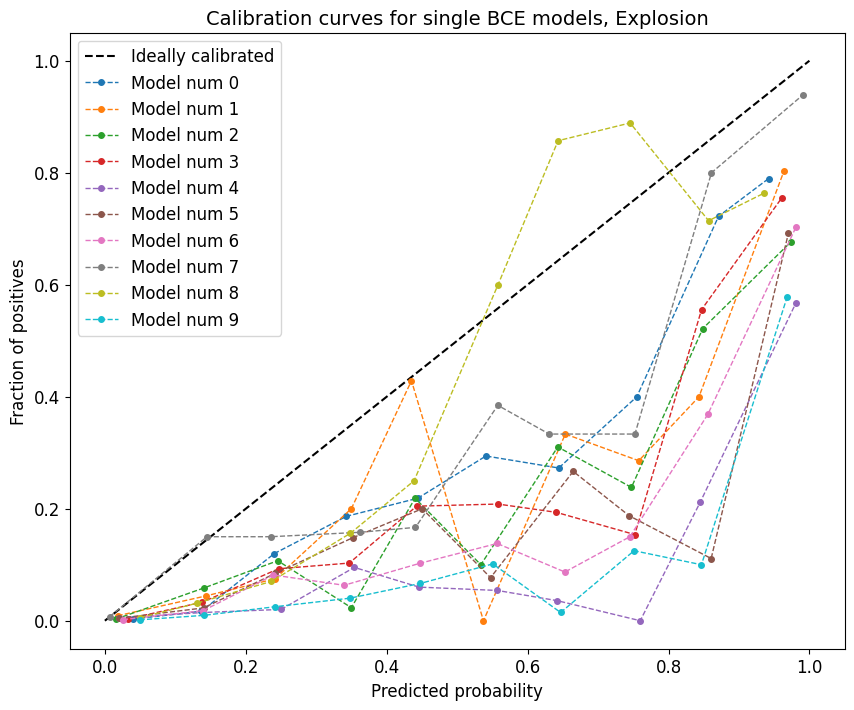

In [28]:
title = "Calibration curves for single BCE models, Explosion"

plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda"
);

# Beta calibration

## HAR

In [8]:
model_type = "seq2seq"

# experiments_name = "explosion"
# path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
# path_to_models_folder = "saved_models/bce/explosion/layer_norm/train_anomaly_num_155"

experiments_name = "human_activity"
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [12]:
from betacal import BetaCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [5]:
cpd_model = ens_bce.models_list[0]

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    cpd_model,
    test_dataloader,
    model_type=model_type,
    device="cuda",
    verbose=True,
)

test_out_flat = torch.vstack(test_out_bank).flatten()
test_labels_flat = torch.vstack(test_labels_bank).flatten()

 14%|█▍        | 3/21 [00:00<00:00, 24.18it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:00<00:00, 25.63it/s]


In [7]:
cal_probas = test_out_flat.numpy()
y_cal = test_labels_flat.numpy()

bc = BetaCalibration(parameters="abm")
bc.fit(cal_probas.reshape(-1, 1), y_cal)

preds_cal = bc.predict(cal_probas)
preds_cal.shape

(26740,)

In [8]:
from sklearn.calibration import calibration_curve

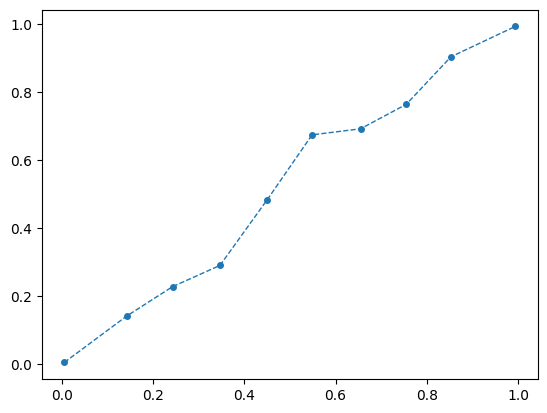

In [9]:
prob_true, prob_pred = calibration_curve(y_cal, preds_cal, n_bins=10)
i = 0
plt.plot(
    prob_pred,
    prob_true,
    linestyle="--",
    marker="o",
    markersize=4,
    linewidth=1,
    label=f"Model num {i}",
)

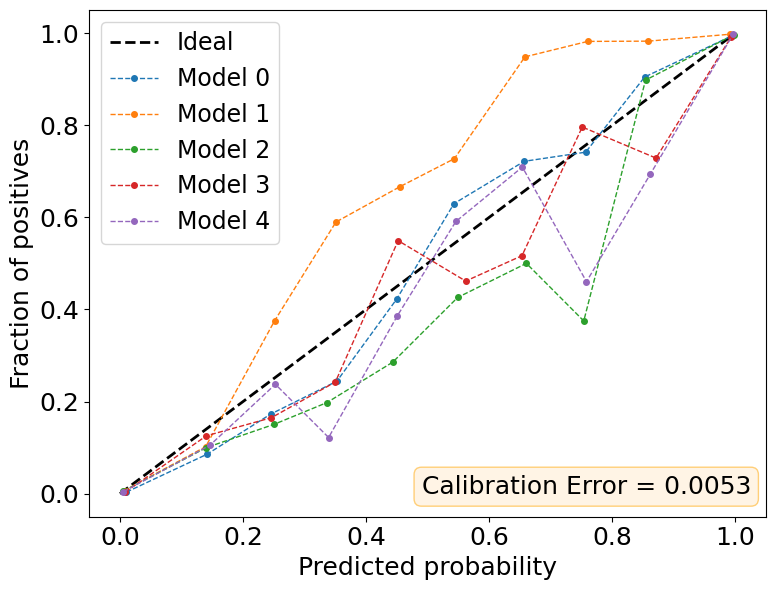

In [9]:
title = "BCE ensemble model before calibration. HAR"

plot_calibration_curves(
    ens_bce,
    test_dataloader,
    # title=title,
    n_bins=10,
    device="cpu",
    verbose=False,
    calibrated=False,
    evaluate=True,
    fontsize=18,
    # savename="bce_har_before",
    model_num=5,
)

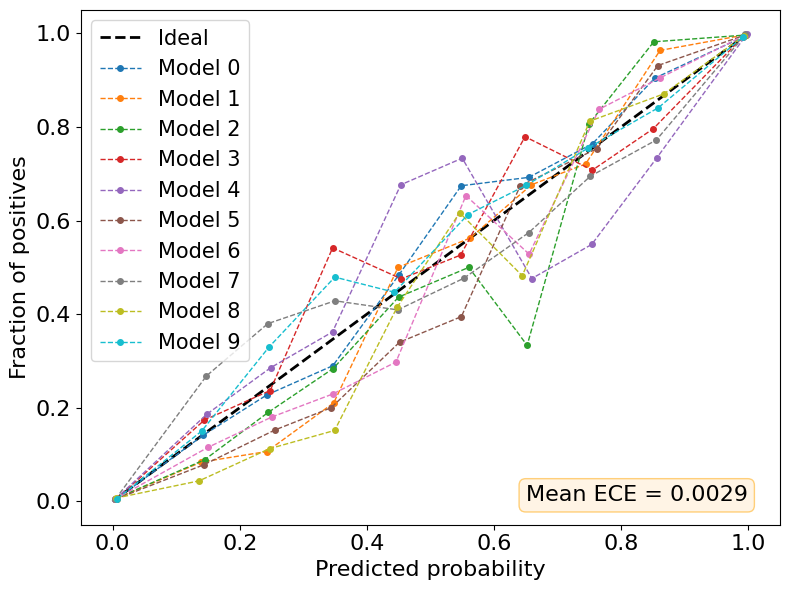

In [20]:
_ = calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    cal_type="beta",
    verbose=False,
    device="cpu",
)

title = "BCE ensemble model after calibration. HAR"
plot_calibration_curves(
    ens_bce,
    test_dataloader,
    n_bins=10,
    # title=title,
    device="cpu",
    verbose=False,
    calibrated=True,
    evaluate=True,
    fontsize=16,
    savename="bce_har_after",
)

# Explosions

In [3]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = (
    "saved_models/bce/explosion/layer_norm/train_anomaly_num_155/ens_1"
)

# experiments_name = "human_activity"
# path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"
# path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [7]:
# title = "BCE ensemble model before calibration. Explosions"
# plot_calibration_curves(
#     ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
# )

In [7]:
test_dataloader_shuffle = DataLoader(test_dataset, batch_size=40, shuffle=True)

In [5]:
from src.utils.visualize import visualize_predictions

In [ ]:
test_batch_1, test_labels_1 = next(iter(test_dataloader_shuffle))
test_batch_2, test_labels_2 = next(iter(test_dataloader_shuffle))

visualize_predictions(
    model=ens_bce,
    model_type="ensemble",
    sequences_batch=test_batch_1,
    labels_batch=test_labels_1,
    device="cuda",
    n_pics=40,
)

In [ ]:
visualize_predictions(
    model=ens_bce,
    model_type="ensemble",
    sequences_batch=test_batch_2,
    labels_batch=test_labels_2,
    device="cuda",
    n_pics=40,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


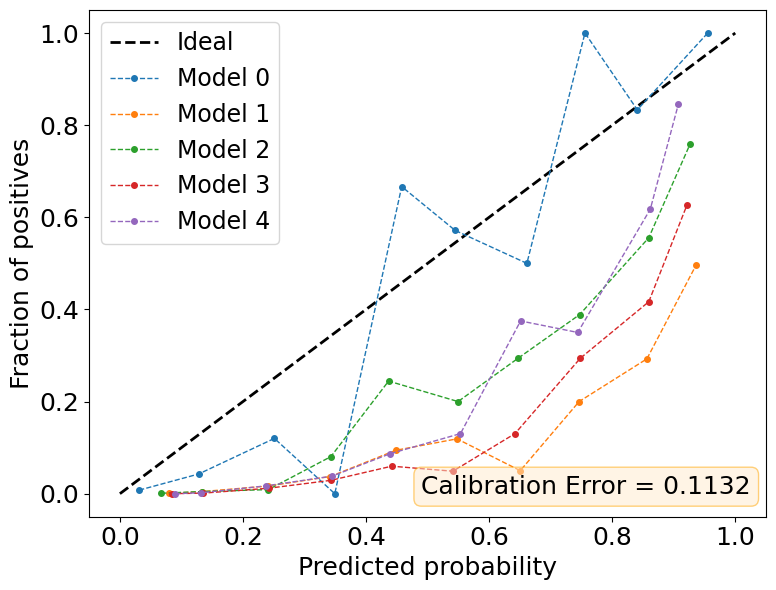

In [12]:
title = "BCE ensemble model before calibration. Explosions"

plot_calibration_curves(
    ens_bce,
    test_dataloader,
    # title=title,
    n_bins=10,
    device="cuda",
    verbose=True,
    calibrated=False,
    evaluate=True,
    fontsize=18,
    savename="bce_explosions_before_CLEAN",
    model_num=5,
)

# plot_calibration_curves(
#     ens_bce,
#     test_dataloader,
#     # title=title,
#     n_bins=15,
#     device="cuda",
#     verbose=True,
#     calibrated=False,
#     evaluate=True,
#     savename="bce_explosions_before_15",
# )

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


 35%|███▌      | 7/20 [00:17<00:31,  2.46s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


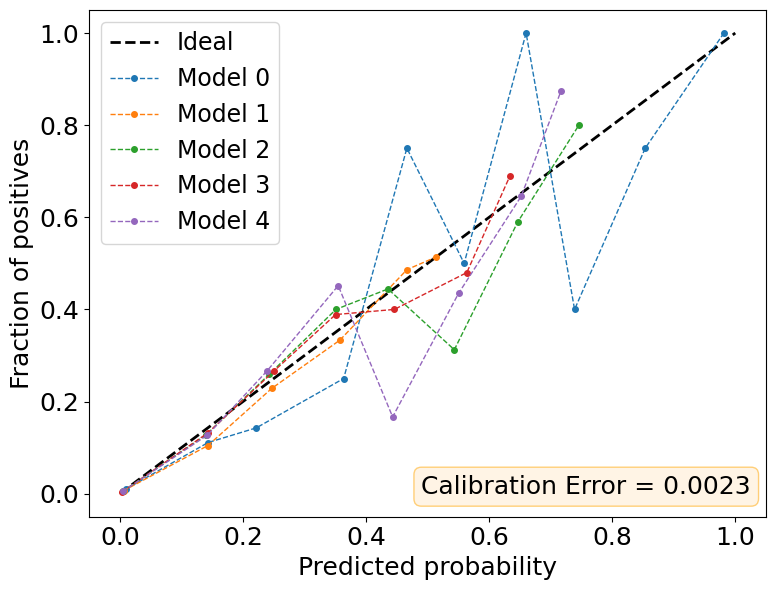

In [13]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

title = "BCE ensemble model before calibration. Explosions"
plot_calibration_curves(
    ens_bce,
    test_dataloader,
    # title=title,
    n_bins=10,
    device="cuda",
    verbose=True,
    calibrated=True,
    evaluate=True,
    fontsize=18,
    savename="bce_explosions_after_CLEAN",
    model_num=5,
)

# plot_calibration_curves(
#     ens_bce,
#     test_dataloader,
#     # title=title,
#     n_bins=15,
#     device="cuda",
#     verbose=True,
#     calibrated=True,
#     evaluate=True,
#     fontsize=16,
#     savename="bce_explosions_after_15",
# )

In [ ]:
visualize_predictions(
    model=ens_bce,
    model_type="ensemble",
    sequences_batch=test_batch_1,
    labels_batch=test_labels_1,
    device="cuda",
    n_pics=40,
)

visualize_predictions(
    model=ens_bce,
    model_type="ensemble",
    sequences_batch=test_batch_2,
    labels_batch=test_labels_2,
    device="cuda",
    n_pics=40,
)

## Road Accidents

In [6]:
model_type = "seq2seq"

experiments_name = "road_accidents"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/road_accidents/layer_norm/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


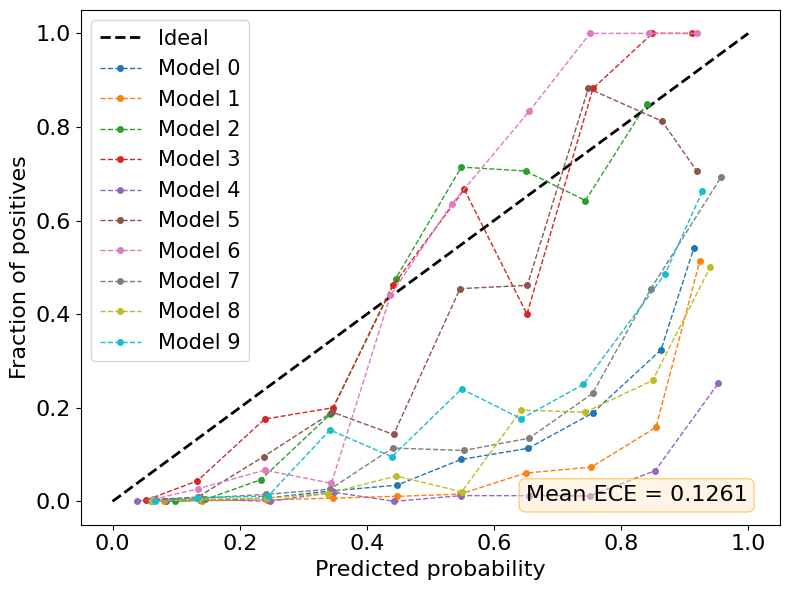

In [7]:
title = "BCE ensemble model before calibration. Road Accidents"
plot_calibration_curves(
    ens_bce,
    test_dataloader,
    # title=title,
    n_bins=10,
    device="cuda",
    verbose=True,
    calibrated=False,
    evaluate=True,
    fontsize=16,
    savename="bce_road_accidents_before",
)

# plot_calibration_curves(
#     ens_bce,
#     test_dataloader,
#     # title=title,
#     n_bins=15,
#     device="cuda",
#     verbose=True,
#     calibrated=False,
#     evaluate=True,
#     savename="bce_road_accidents_before_15",
# )

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


 35%|███▌      | 7/20 [00:19<00:35,  2.71s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:55<00:00,  2.75s/it]


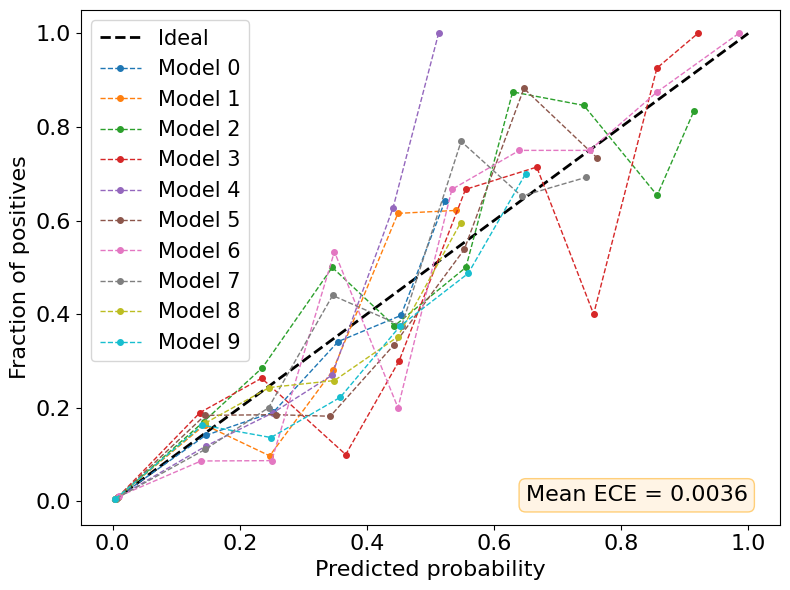

In [8]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

title = "BCE ensemble model after calibration. Road Accidents"
plot_calibration_curves(
    ens_bce,
    test_dataloader,
    # title=title,
    n_bins=10,
    device="cuda",
    verbose=True,
    calibrated=True,
    evaluate=True,
    fontsize=16,
    savename="bce_road_accidents_after",
)

# plot_calibration_curves(
#     ens_bce,
#     test_dataloader,
#     # title=title,
#     n_bins=15,
#     device="cuda",
#     verbose=True,
#     calibrated=True,
#     evaluate=True,
#     fontsize=16,

#     savename="bce_road_accidents_after_15",
# )

In [7]:
import matplotlib.pyplot as plt
import numpy as np

NUM_BINS = 20


def plot_calibration_map(scores_set, prob, legend_set, alpha=1, **kwargs):
    # rc('text', usetex=True)
    fig_reliability_map = plt.figure("reliability_map")
    fig_reliability_map.clf()
    ax_reliability_map = plt.subplot(111)
    ax = ax_reliability_map
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlim([-0.01, 1.01])
    ax.set_xlabel(("s"), fontsize=16)
    ax.set_ylabel(("hat(p)"), fontsize=16)
    n_lines = len(legend_set)
    bins = np.linspace(0, 1, NUM_BINS + 1)
    hist_tot = np.histogram(prob[0], bins=bins)
    hist_pos = np.histogram(prob[0][prob[1] == 1], bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2.0
    empirical_p = np.true_divide(hist_pos[0] + alpha, hist_tot[0] + 2 * alpha)

    ax.plot(centers, empirical_p, "ko", label="empirical")

    for scores, legend in zip(scores_set, legend_set):
        if legend == "isotonic":
            pr_iso, sc_iso = get_iso_points(scores, prob[2])
            ax.plot(sc_iso, pr_iso, "-", label=legend, linewidth=n_lines, **kwargs)
        elif legend != "uncalib":
            ax.plot(prob[2], scores, "-", label=legend, linewidth=n_lines, **kwargs)
        n_lines -= 1
    ax.legend(loc="upper left")
    return fig_reliability_map


def get_iso_points(probas, scores):
    n = len(scores)
    pr_iso = []
    sc_iso = []
    for i in np.arange(n - 1):
        s = scores[i]
        p = probas[i]
        if probas[i + 1] == p and scores[i + 1] > s:
            pr_iso.append(p)
            sc_iso.append(s)
        elif probas[i + 1] > p and scores[i + 1] > s:
            pr_iso.append(p)
            sc_iso.append(s)
            sc_iso.append(scores[i + 1])
            pr_iso.append(p)
    return pr_iso, sc_iso

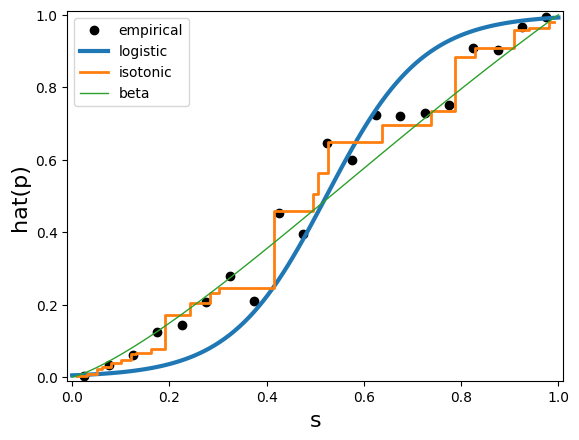

In [8]:
cal_probas = test_out_flat.numpy()
y_cal = test_labels_flat.numpy()

lr = LogisticRegression(C=99999999999)
lr.fit(cal_probas.reshape(-1, 1), y_cal)

iso = IsotonicRegression()
iso.fit(cal_probas, y_cal)

bc = BetaCalibration(parameters="abm")
bc.fit(cal_probas.reshape(-1, 1), y_cal)

linspace = np.linspace(0, 1, 100)
idx = cal_probas.argsort()
scores = cal_probas[idx]
y_c_2 = y_cal[idx]


pr = [
    lr.predict_proba(linspace.reshape(-1, 1))[:, 1],
    iso.predict(linspace),
    bc.predict(linspace),
]

methods_text = ["logistic", "isotonic", "beta"]
fig_map = plot_calibration_map(pr, [scores, y_c_2, linspace], methods_text, alpha=0)

(100,)